In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def flatLCDM(z, H0, Om):
    return H0*np.sqrt(Om*(1 + z)**3 + 1 - Om)

In [3]:
zhzi, hzi, shzi = np.genfromtxt('data/Hz32Clocks.txt', comments='#', usecols=(0,1, 2), unpack=True)

In [4]:
np.random.seed(111)
z_mock = np.random.choice(zhzi, size=100, replace=True)
z_mock = np.sort(np.round(z_mock + np.random.normal(0, 0.01, size=100), 2))

In [5]:
H0 = 67.4
Om = 0.315

H_real = flatLCDM(z_mock, H0, Om)

In [6]:
sigma_mock = 0.07*H_real

In [7]:
H_obs = np.random.normal(H_real, sigma_mock)

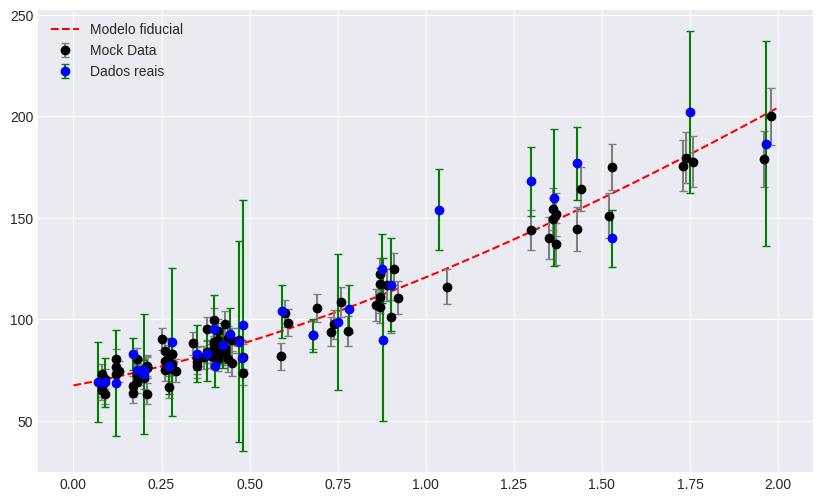

In [26]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

z_range = np.linspace(0, 2, 200)
H_theory_curve = flatLCDM(z_range, H0, Om)
ax.plot(z_range, H_theory_curve, color='red', linestyle='--', label="Modelo fiducial")
ax.errorbar(z_mock, H_obs, yerr=sigma_mock, fmt='o', color='black', ecolor='gray', capsize=3, label='Mock Data')
ax.errorbar(zhzi, hzi, yerr=shzi, fmt='o', color='blue', ecolor='green', capsize=3, label="Dados reais")
plt.legend()
plt.show()

In [8]:
%matplotlib inline
import emcee
import corner
import time
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
import scipy.integrate as integrate
import scipy.linalg as linalg
import IPython
from matplotlib.ticker import MaxNLocator
from multiprocessing.pool import ThreadPool
from getdist import plots, MCSamples, loadMCSamples, types
from scipy.special import gamma
from scipy.integrate import quad

global argsortz #array de indices de zsni ordenados

import os
os.environ["OMP_NUM_THREADS"] = "1"

np.random.seed(321)

In [9]:
zhzi = z_mock
hzi = H_obs
shzi = sigma_mock
ndata=len(zhzi)

In [10]:
pl.rcParams['text.usetex'] = True
pl.rcParams.update(pl.rcParamsDefault)
priorArray = np.array([[50., 100.], [0.0, 3.0], [-3.0, 3.0], [0.1, 2]])
nstepHz = 5000

In [11]:
#Function to identify which model will be used
def free_par(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f = theta
            return [h0, wm, wl, f]
        elif flat == True:
            h0, wm, f = theta
            return [h0, wm, 1-wm, f]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl = theta
            return [h0, wm, wl, 1]
        elif flat == True:
            h0, wm = theta
            return [h0, wm, 1-wm, 1]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2Hz(par):
    E2 = par[1]*(1+zhzi)**3+(1-par[1]-par[2])*(1+zhzi)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[0]*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = inv_cov/par[3]**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHz(par):
    for i in range(len(par)):
        if not priorArray[i][0] < par[i] < priorArray[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHz(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])

def lnlikeHzA(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])


def lnprobHz(theta, freef, flat):
    par = free_par(theta, freef, flat)
    
    lp = lnpriorHz(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHz(par)

#Minimize chi2
def find_bestfit(lnlike, par_ml, parnames, freef, flat):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat: -2*lnlike(par_ml, freef, flat)
    result = op.minimize(chi2, par_ml, args=(freef, flat))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

#Run MC
def run_emcee(par_ml, nwalkers, lnprob, freef, flat, ainput, nsteps):
    ndim = len(par_ml)
    pos = [par_ml +1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    with ThreadPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[freef, flat], a=ainput, pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)
    
    accept = sampler.acceptance_fraction
    print('Acceptance fraction:',accept)
    print('Minimum acceptance:',np.amin(accept))
    print('Maximum acceptance:',np.amax(accept))
    
    return sampler

#Remove burn in
def tira_burnin(sampler, burnin, ndim):
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    return samples


def burninthin(sampler, tau):
    taumax = np.amax(tau)
    taumin = np.amin(tau)
    samples = sampler.get_chain(discard=int(2*taumax), thin=int(taumin/2), flat=True)
    print(samples.shape)
    return samples

#MC results
def MC_result(samples, par_ml, parnames):
    ndim = len(par_ml)
    par_mean = np.mean(samples,axis=0)
    par_median = np.percentile(samples, [50], axis=0)[0]
    par_valm = np.percentile(samples, [15.865525393149998], axis=0)[0]
    par_valp = np.percentile(samples, [84.13447460685], axis=0)[0]
    par_valm2 = np.percentile(samples, [2.275013194800002], axis=0)[0]
    par_valp2 = np.percentile(samples, [97.7249868052], axis=0)[0]
    par_sigm = par_mean - par_valm
    par_sigp = par_valp - par_mean
    par_sigm2 = par_mean - par_valm2
    par_sigp2 = par_valp2 - par_mean
    print('MCMC result:')
    for i in range(ndim):
        print("""{0} = {1:5.5f} +{2:5.5f} +{3:5.5f} -{4:5.5f} -{5:5.5f} (median: {6:5.5f}, ml: {7:5.5f})"""\
              .format(parnames[i],par_mean[i],par_sigp[i],par_sigp2[i],par_sigm[i],par_sigm2[i],par_median[i],par_ml[i]))

#Insert a derived paramater
def insertDerived(sample, parnames, parlabel, num, gsample, derived, derivedName, derivedLabel):
    n = np.zeros(num)
    
    if derivedName not in parnames:
        newSample = np.c_[sample, derived]
        parnames.append(derivedName)
        gsample.addDerived(derived, name=derivedName, label=derivedLabel)
        
        return newSample, gsample, parnames, n

    elif derivedName in parnames:
        print('Parâmetro dependente já adicionado.')

        return sample, gsample, parnames, n

#Distribution funcion for chi2
def chiDist(chi, n):
    return (n**(n/2)*((chi)**((n-2)/2))*np.exp(-(n/2)*chi))/(2**(n/2)*gamma(n/2))

#Calculate cdf for chiDist
def chiCDF(x, n):
    res = np.zeros_like(x)
    for i, val in enumerate(x):
        y, err = quad(chiDist, 0, val, args=(n))
        res[i]=y
    return res

#Plot chi2 cdf
def plotChiDist(chimin, par, name=0):
    n = ndata - par
    chi = np.linspace(0, 2.5, 500)
    chiv = np.full((500), chimin/n)
    hv = chiDist(chi, n)
    cdf = chiCDF(chi, n)
    y = np.linspace(0, 1.8, 500)
    
    pl.plot(chi, hv, label=r"$h _{\nu}$")
    pl.plot(chiv, y, '--', label=r"$\chi _{\nu} ^{2}$" + "$= {0}$".format(np.round(chimin/n, 3)))
    pl.plot(chi, cdf, '--', label="cdf")
    
    pl.xticks(np.arange(0.0, 2.51, 0.5))
    pl.yticks(np.arange(0.0, 1.76, 0.25))
    pl.axis((0, 2.5, 0, 1.75))
    pl.grid(linestyle='-.', linewidth='0.5')
    pl.minorticks_on()
    
    pl.ylabel(r'$h_{\nu}$')
    pl.xlabel(r'$\chi _{\nu} ^{2}$')
    pl.legend(loc='best')
   
    if not name == 0:
        pl.savefig(name+'.pdf')
    
    pl.show()

In [12]:
cov_mat = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    cov_mat[i,i] = shzi[i]**2

inv_cov = linalg.inv(cov_mat)

# No factor f

In [13]:
par_HzF = [69.1929957609451, 0.2480895086492853]
ndimF = len(par_HzF)
prefixF = 'FlatLcdmHz32Cov'
parlabelsF = ["H_0","\\Omega_m"]
parlabtexF = ["$H_0$","$\\Omega_m$"]
parnamesF = ['H0','wm']

resultHzF = find_bestfit(lnprobHz, par_HzF, parnamesF, freef=False, flat=True)
par_mlHzF = resultHzF['x']

Maximum likelihood result:
H0  =  67.87414489148716
wm  =  0.3008134258521129
chi2min = 100.83969734894698
Total time: 0.014 seg


In [14]:
samplerHzF = run_emcee(par_HzF, 100, lnprobHz, False, True, 2.0, nstepHz)

100%|██████████████████████████████████████| 5000/5000 [00:36<00:00, 137.60it/s]

Acceptance fraction: [0.7104 0.7302 0.7042 0.7136 0.7112 0.7136 0.7142 0.717  0.715  0.722
 0.7134 0.721  0.7096 0.7136 0.72   0.7202 0.7236 0.7072 0.7162 0.71
 0.714  0.7186 0.7094 0.7092 0.7268 0.7258 0.7108 0.7128 0.714  0.7202
 0.7088 0.7222 0.7256 0.7234 0.7204 0.7188 0.7158 0.7126 0.7078 0.715
 0.7028 0.7244 0.713  0.716  0.7176 0.7368 0.7068 0.7186 0.7324 0.7146
 0.7112 0.7186 0.7234 0.7212 0.7104 0.7162 0.7134 0.7096 0.7014 0.7184
 0.7114 0.7066 0.7224 0.7122 0.7166 0.714  0.706  0.7086 0.7116 0.7136
 0.7188 0.7074 0.7244 0.7024 0.728  0.7176 0.7272 0.719  0.7118 0.7238
 0.711  0.724  0.7196 0.7158 0.7146 0.7162 0.7026 0.7142 0.7224 0.7188
 0.7196 0.7038 0.7128 0.7202 0.7142 0.6976 0.7228 0.711  0.7262 0.7136]
Minimum acceptance: 0.6976
Maximum acceptance: 0.7368


In [15]:
tauHzF = samplerHzF.get_autocorr_time()
print(tauHzF)

tauHzmaxF = np.amax(tauHzF)
r = nstepHz/tauHzmaxF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[30.88991426 31.78910063]
157.28661399327092
Convergiu! :)


In [16]:
samplesHzFFF = burninthin(samplerHzF, tauHzF)

(32900, 2)


In [17]:
MC_result(samplesHzFFF, par_HzF, parnamesF)

MCMC result:
H0 = 67.83735 +0.94862 +1.86512 -0.94717 -1.90673 (median: 67.84433, ml: 69.19300)
wm = 0.30188 +0.01817 +0.03768 -0.01821 -0.03524 (median: 0.30144, ml: 0.24809)


In [18]:
gsamplesHzFFF = MCSamples(samples=samplesHzFFF, names=parnamesF, labels=parlabelsF, ranges={'wm':(0, None)})
gsamplesHzFFF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


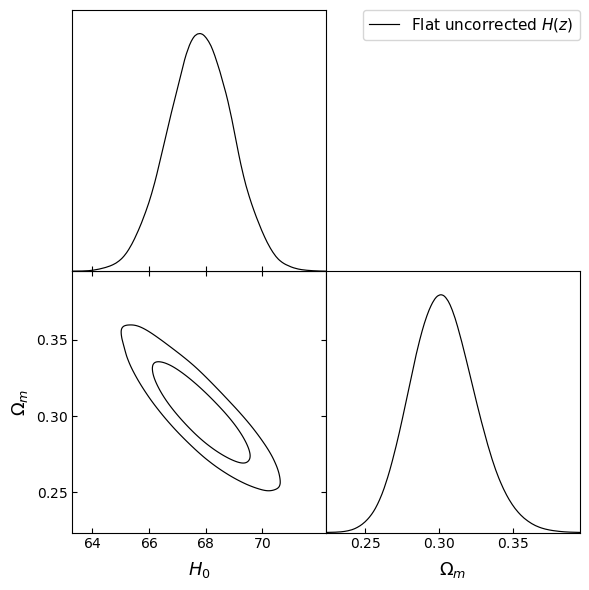

In [29]:
g = plots.getSubplotPlotter(width_inch=6)
g.triangle_plot([gsamplesHzF], filled=False, legend_labels=['Flat uncorrected $H(z)$'])
pl.show()
#g.export('fig/g'+prefixF+'All-triangle.pdf')

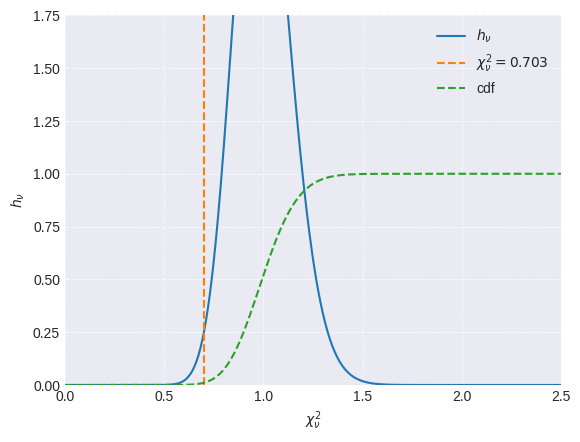

Probabilidade =  1.1227778689922645
Chiv =  0.7028326928002921


In [44]:
chi2F=chi2Hz(free_par([67.83735,0.30188], freef=False, flat=True))
plotChiDist(chi2F, len(par_HzF), name='No_f')
chivFperc, errF = quad(chiDist, 0, chi2F/(ndata-len(par_HzF)), args=(ndata-len(par_HzF)))
print('Probabilidade = ', chivFperc*100)
print('Chiv = ', chi2F/(ndata-len(par_HzF)))

# Colocando f

In [20]:
f = 1.21
f_shzi = f*shzi

In [21]:
cov_mat = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    cov_mat[i,i] = f_shzi[i]**2

inv_cov = linalg.inv(cov_mat)

In [22]:
par_HzF = [69.1929957609451, 0.2480895086492853]
ndimF = len(par_HzF)
prefixF = 'FlatLcdmHz32Cov'
parlabelsF = ["H_0","\\Omega_m"]
parlabtexF = ["$H_0$","$\\Omega_m$"]
parnamesF = ['H0','wm']

resultHzF = find_bestfit(lnprobHz, par_HzF, parnamesF, freef=False, flat=True)
par_mlHzF = resultHzF['x']

Maximum likelihood result:
H0  =  67.87414501171116
wm  =  0.3008134234741288
chi2min = 68.8748701242725
Total time: 0.014 seg


In [23]:
samplerHzF = run_emcee(par_HzF, 100, lnprobHz, False, True, 2.0, nstepHz)

100%|██████████████████████████████████████| 5000/5000 [00:36<00:00, 136.31it/s]

Acceptance fraction: [0.731  0.7174 0.707  0.7228 0.718  0.7056 0.7006 0.7166 0.718  0.7164
 0.7174 0.7196 0.7122 0.7184 0.7062 0.7308 0.7218 0.7042 0.722  0.7216
 0.7088 0.7202 0.7154 0.72   0.7136 0.7208 0.7116 0.7192 0.7274 0.7138
 0.7126 0.7096 0.7168 0.7214 0.7082 0.7134 0.7162 0.7268 0.6982 0.7136
 0.701  0.713  0.724  0.7196 0.7126 0.717  0.7124 0.7242 0.7322 0.7078
 0.7044 0.7268 0.715  0.7218 0.703  0.7194 0.7214 0.7082 0.7118 0.7116
 0.7096 0.7076 0.7252 0.722  0.7198 0.7258 0.7094 0.7002 0.7186 0.7212
 0.7272 0.7202 0.7008 0.7108 0.7186 0.7234 0.7178 0.7104 0.706  0.7234
 0.7094 0.7204 0.713  0.7262 0.7178 0.714  0.7092 0.713  0.7174 0.715
 0.7114 0.7112 0.722  0.7188 0.7156 0.7116 0.7276 0.7074 0.711  0.7078]
Minimum acceptance: 0.6982
Maximum acceptance: 0.7322


In [24]:
tauHzF = samplerHzF.get_autocorr_time()
print(tauHzF)

tauHzmaxF = np.amax(tauHzF)
r = nstepHz/tauHzmaxF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[31.35262011 32.33372379]
154.63730784483334
Convergiu! :)


In [25]:
samplesHzF = burninthin(samplerHzF, tauHzF)

(32900, 2)


In [26]:
MC_result(samplesHzF, par_HzF, parnamesF)

MCMC result:
H0 = 67.80393 +1.14224 +2.27674 -1.14692 -2.31062 (median: 67.80719, ml: 69.19300)
wm = 0.30269 +0.02207 +0.04671 -0.02195 -0.04186 (median: 0.30208, ml: 0.24809)


In [27]:
gsamplesHzF = MCSamples(samples=samplesHzF, names=parnamesF, labels=parlabelsF, ranges={'wm':(0, None)})
gsamplesHzF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


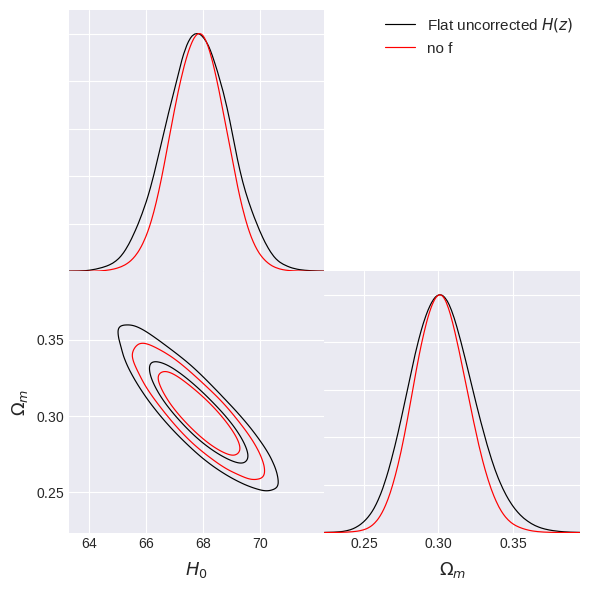

In [45]:
g = plots.getSubplotPlotter(width_inch=6)
g.triangle_plot([gsamplesHzF, gsamplesHzFFF], filled=False, legend_labels=['Flat uncorrected $H(z)$', 'no f'])
pl.show()
g.export('fig/comF_semF.pdf')

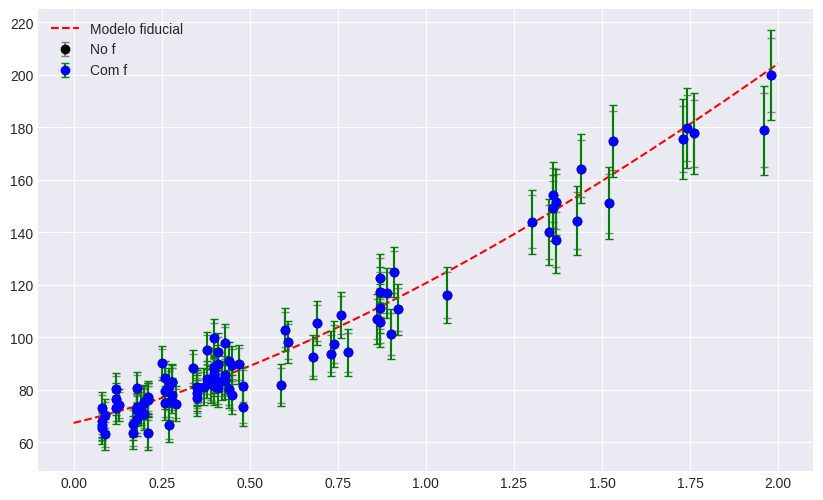

In [31]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

z_range = np.linspace(0, 2, 200)
H_theory_curve = flatLCDM(z_range, H0, Om)
ax.plot(z_range, H_theory_curve, color='red', linestyle='--', label="Modelo fiducial")
ax.errorbar(zhzi, hzi, yerr=shzi, fmt='o', color='black', ecolor='gray', capsize=3, label='No f')
ax.errorbar(zhzi, hzi, yerr=f_shzi, fmt='o', color='blue', ecolor='green', capsize=3, label="Com f")
plt.legend()
plt.show()

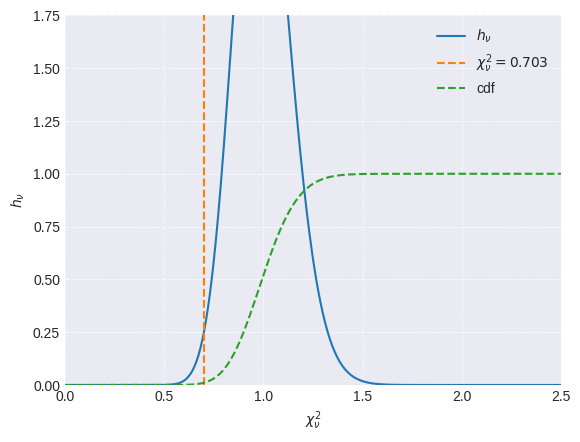

Probabilidade =  1.1241566889697416
Chiv =  0.702885327932422


In [46]:
chi2F=chi2Hz(free_par([67.80393,0.30269], freef=False, flat=True))
plotChiDist(chi2F, len(par_HzF), 'com_f')
chivFperc, errF = quad(chiDist, 0, chi2F/(ndata-len(par_HzF)), args=(ndata-len(par_HzF)))
print('Probabilidade = ', chivFperc*100)
print('Chiv = ', chi2F/(ndata-len(par_HzF)))

# com f

In [33]:
par_HzFf = [69.1929957609451,0.2480895086492853, .9]
ndimFf = len(par_HzFf)
prefixFf = 'LcdmHz32CovCorr'
parlabelsFf = ['H_0','\\Omega_m', 'f']
parlabtexFf = ['$H_0$','$\\Omega_m$', '$f$']
parnamesFf = ['H0','wm', 'f']

resultHzFf = find_bestfit(lnprobHz, par_HzFf, parnamesFf, freef=True, flat=True)
par_mlHzFf = resultHzFf['x']

Maximum likelihood result:
H0  =  67.87415298766004
wm  =  0.3008127924089721
f  =  0.8299056548381314
chi2min = 62.71211958711745
Total time: 0.043 seg


/home/nirk20/jupyter_venv/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [34]:
samplerHzFf = run_emcee(par_HzFf, 100, lnprobHz, True, True, 2.0, nstepHz)

100%|██████████████████████████████████████| 5000/5000 [00:35<00:00, 140.24it/s]

Acceptance fraction: [0.6524 0.6522 0.642  0.651  0.6468 0.6508 0.6438 0.6382 0.6448 0.6544
 0.6366 0.6492 0.6436 0.6516 0.6352 0.6632 0.6554 0.6442 0.6484 0.6542
 0.6438 0.643  0.6404 0.6388 0.6516 0.649  0.6574 0.6438 0.6402 0.6528
 0.6526 0.6474 0.6482 0.653  0.6548 0.6436 0.6438 0.6568 0.64   0.6494
 0.6306 0.6344 0.6516 0.6438 0.6572 0.6422 0.645  0.65   0.6604 0.6462
 0.6404 0.6456 0.6534 0.6452 0.6474 0.6494 0.6518 0.6306 0.6446 0.6454
 0.6376 0.6488 0.6498 0.6554 0.6374 0.6508 0.651  0.6392 0.6488 0.6562
 0.6414 0.6476 0.6436 0.6376 0.641  0.6428 0.6498 0.6326 0.6418 0.6446
 0.645  0.6512 0.6476 0.6454 0.6414 0.6482 0.633  0.6416 0.6624 0.6478
 0.6462 0.645  0.6562 0.6502 0.6498 0.644  0.6472 0.6346 0.643  0.6392]
Minimum acceptance: 0.6306
Maximum acceptance: 0.6632


In [35]:
tauHzFf = samplerHzFf.get_autocorr_time()
print(tauHzFf)

tauHzmaxFf = np.amax(tauHzFf)
r = nstepHz/tauHzmaxFf
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[37.34962398 37.2675898  36.6963545 ]
133.87015628727963
Convergiu! :)


In [36]:
samplesHzFf = burninthin(samplerHzFf, tauHzFf)

(27300, 3)


In [37]:
MC_result(samplesHzFf, par_mlHzFf, parnamesFf)

MCMC result:
H0 = 67.83195 +0.96521 +1.94284 -0.95718 -1.94165 (median: 67.83562, ml: 67.87415)
wm = 0.30186 +0.01856 +0.03884 -0.01851 -0.03577 (median: 0.30135, ml: 0.30081)
f = 0.84930 +0.06031 +0.13383 -0.06083 -0.11226 (median: 0.84586, ml: 0.82991)


In [38]:
gsamplesHzFf = MCSamples(samples=samplesHzFf, names=parnamesFf, labels=parlabelsFf, ranges={'wm':(0, None)})
gsamplesHzFf.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


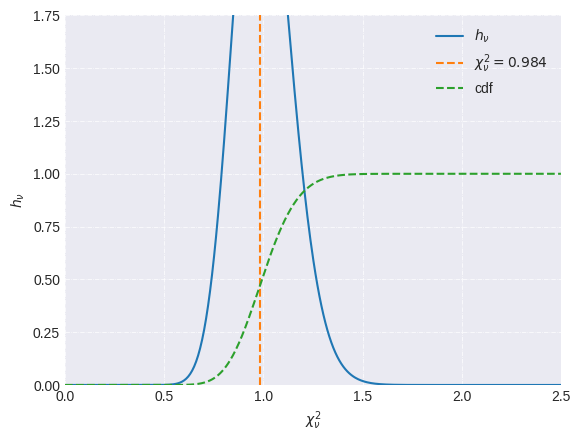

Probabilidade =  47.518725170915324
Chiv =  0.9842614268121309


In [47]:
chi2Ff=chi2Hz(free_par([67.82460,0.30215,0.84938], freef=True, flat=True))
plotChiDist(chi2Ff, len(par_HzFf), name='corrigido')
chivFfperc, errF = quad(chiDist, 0, chi2Ff/(ndata-len(par_HzFf)), args=(ndata-len(par_HzFf)))
print('Probabilidade = ', chivFfperc*100)
print('Chiv = ', chi2Ff/(ndata-len(par_HzFf)))

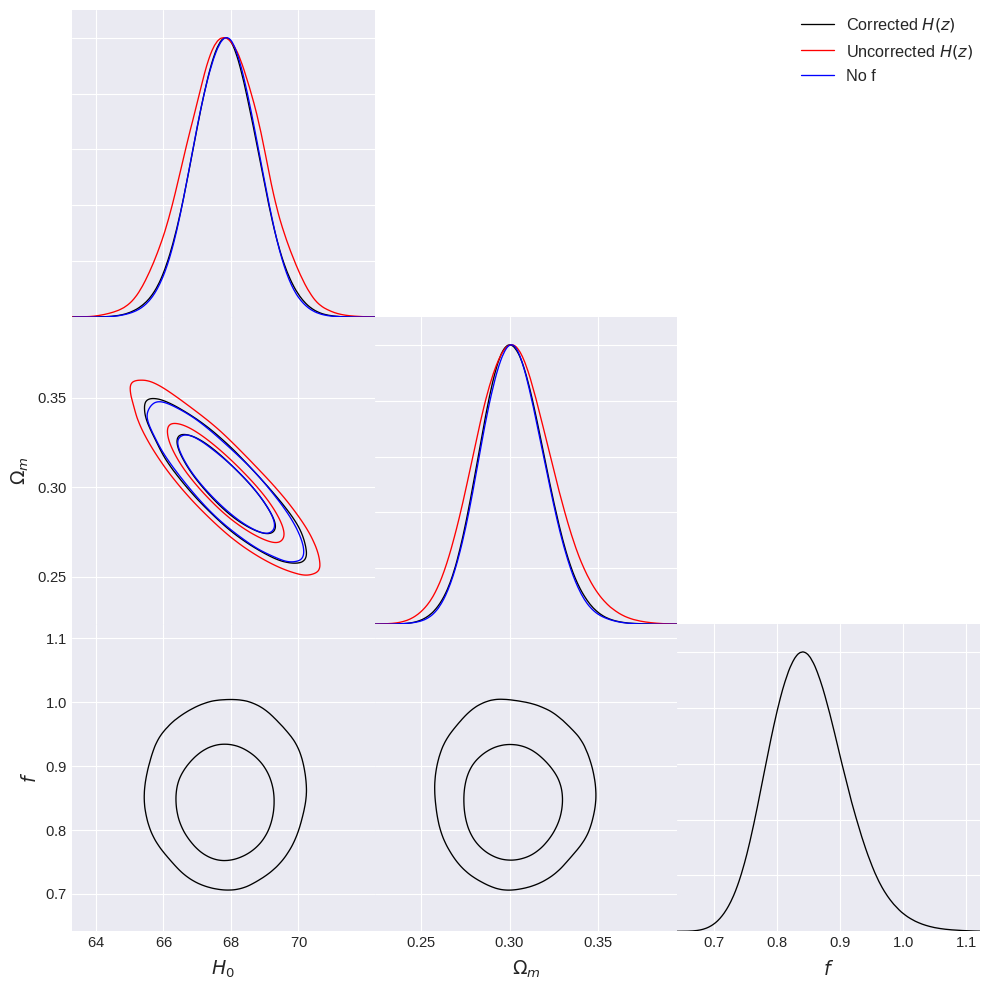

In [42]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzFf, gsamplesHzF, gsamplesHzFFF], [parnamesFf[0],parnamesFf[1],parnamesFf[2]], filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$', 'No f'])
g.export('fig/triangle_ALL')
plt.show()